# Multiscale localisation

First, import necessary library to load and display images

In [1]:
import sys
sys.path.append('../..')
import numpy as np

from matplotlib import pyplot as plt
from colloids import track
%matplotlib inline

We also need to define a function to quickly plot circles of different sizes on a figure

In [2]:
def draw_circles(xs, ys, rs, **kwargs):
    for x,y,r in zip(xs,ys,rs):
        circle = plt.Circle((x,y), radius=r, **kwargs)
        plt.gca().add_patch(circle)

Load a picture containing bright particles on a dark background and immediatly display this image in a figure

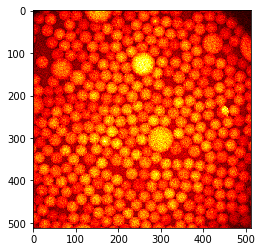

In [3]:
im = plt.imread('droplets.jpg')
plt.imshow(im, 'hot');
plt.show()

Create a finder object of the same shape as the image. 
This actually creates many sub-finder objects, one for each \\Octave\\. Octave 1 has the same shape as the image. Octave 2 is twice smaller. Octave 3 is four time smaller than Octave 1, etc. Optionally, you can create Octave 0 that is twice bigger than Octave 1, but it takes a lot of memory and tracking results are bad. So here we set Octave0=False.
The maximal scale at which particles are looked for is set by nbOctaves.

In [28]:
finder = track.MultiscaleBlobFinder(im.shape, Octave0=False, nbOctaves=4)
finder?

Feed the image in the tracker with default tracking parameters already does a great job. The output has three columns : $(x,y,r,i)$ where $r$ is a first approximation of the radius of the particle (see below) and $i$ is a measure of the brightness of the particle.

The smallest particle that can be detected with the default parameter $k=1.6$ in 2D is about 3 pixels in radius. In 3D it would be 4 pixels in radius. To increase this smallest scale you can increase the parameter $k$. Decreasing $k$ below 1.2 is probably not a good idear since you will detect noise as particles. Redo your acquisition with higher resolution instead.

(324, 4)
smallest particle detected has a radius of 2.88904 px


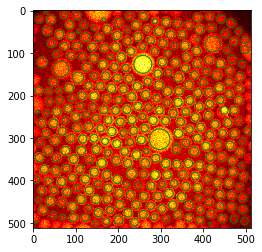

In [29]:
centers = finder(im, k=1.6)
print centers.shape
print "smallest particle detected has a radius of %g px"%(centers[:,-2].min()) 
draw_circles(centers[:,0], centers[:,1], centers[:,2], facecolor='none', edgecolor='g')
plt.imshow(im, 'hot');

However some small particles are missing, for example near the large particle at the center. Maybe it is because by default the MultiscaleFinder removes overlapping particles? Let us try to disable this removal.

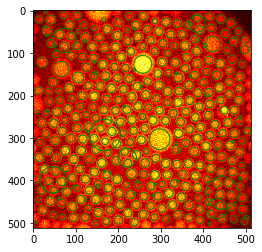

In [6]:
centers = finder(im, removeOverlap=False)
draw_circles(centers[:,0], centers[:,1], centers[:,2], facecolor='none', edgecolor='g')
plt.imshow(im, 'hot');

Well, we gained only spurious detections.

We can also try to disable a filter that rejects local minima that are elongated in space.

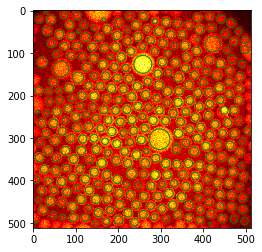

In [7]:
centers = finder(im, maxedge=-1)
draw_circles(centers[:,0], centers[:,1], centers[:,2], facecolor='none', edgecolor='g')
plt.imshow(im, 'hot');

That was it seemingly. Now we have all particles.

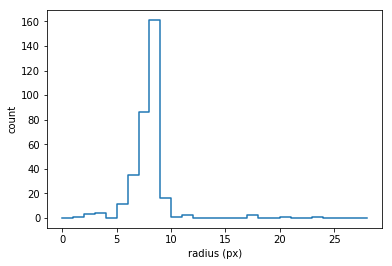

In [8]:
histR0, bins = np.histogram(centers[:,-2], bins=np.arange(30))
plt.step(bins[:-1], histR0);
plt.xlabel('radius (px)');
plt.ylabel('count');

For sanity, it is probably better to filter out the particles with a radius smaller than 1 pixel and with too low intensity.

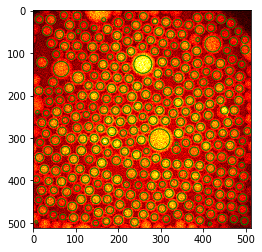

In [9]:
centers = centers[(centers[:,-2]>1) & (centers[:,-1]<-1)]
draw_circles(centers[:,0], centers[:,1], centers[:,2], facecolor='none', edgecolor='g')
plt.imshow(im, 'hot');

## Introspection

The intermediate steps of the algorithm are accessible. For example one can access the octaves (lines in figure below) and their successively blured versions of the original image.

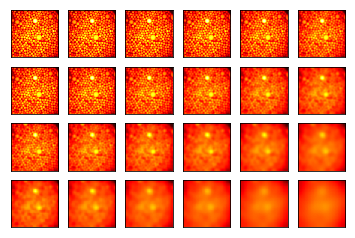

In [10]:
#get maximum intensity to set color bar
m = max([oc.layersG.max() for oc in finder.octaves[1:]])
for o, oc in enumerate(finder.octaves[1:]):
    for l, lay in enumerate(oc.layersG):
        a = plt.subplot(len(finder.octaves)-1,len(oc.layersG),len(oc.layersG)*o + l +1)
        #hide ticks for clarity
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        plt.imshow(lay, 'hot', vmin=0, vmax=m);
        

One can also access the difference of Gaussians. Here relevant values are negative, so we inverse the colors and saturate at zero.

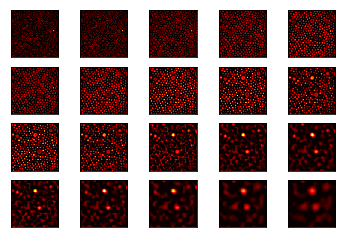

In [11]:
#get maximum intensity to set color bar
m = min([oc.layers.min() for oc in finder.octaves[1:]])
for o, oc in enumerate(finder.octaves[1:]):
    for l, lay in enumerate(-oc.layers):
        a = plt.subplot(len(finder.octaves)-1,len(oc.layers),len(oc.layers)*o + l +1)
        #hide ticks for clarity
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        plt.imshow(lay, 'hot', vmin=0, vmax=-m);
        

Each OctaveFinder looks for local minima (very negative) in the difference of Gaussians space. Local minima in understood relative to space $(x,y)$ and scale $s$.
The job of the MultiscaleFinder is to coordinate the action of the Octaves to return a coherent result.

## From scales to sizes

The multiscale algorithm finds local minima in space and scale $s$. How can we convert scales in actual sizes (particle radius $r$)?
If the particles are far apart, their respective spots do not overlap, so we can use the formula

$ R = s \sqrt{\frac{2d\ln \alpha}{1-\alpha^{-2}}} $

where $d$ is the dimensionality of the image (here 2) and $\alpha=2^{1/n}$ with $n$ the number of subdivisions in an octave (parameter nbLayers when creating the MultiscaleFinder).

MultiscaleFinder actually does this conversion when returning its result.

But what if particles are close together? Then their respective spots overlap and the scale in only indirectly related to the size. We need to take into account the distance between particles and their relative brightnesses. The first step is to revert to scales.

In [12]:
s = track.radius2sigma(centers[:,-2], dim=2)

Then we have to find the couples of particles whoes spots probably overlap. The submodule `colloids.particles` has a function to do this. On a large system, this is the most costly function.

In [13]:
from colloids.particles import get_bonds
bonds, dists = get_bonds(positions=centers[:,:-2], radii=centers[:,-2], maxdist=3.0)

Now we have all the ingredients to run the reconstruction.

Note: You need boost libraries installed on your system to proceed. 

    sudo apt-get install libboost-all-dev
    
First, we will obtain the brightness of each particle form the value of the Difference of Gaussians at the place and scale of every particle, e.g. the last column of centers.

In [14]:
brights1 = track.solve_intensities(s, bonds, dists, centers[:,-1])

Second, we use these brightnesses to obtain the new radii.

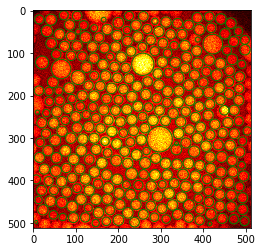

In [15]:
radii1 = track.global_rescale_intensity(s, bonds, dists, brights1)
draw_circles(centers[:,0], centers[:,1], radii1, facecolor='none', edgecolor='g')
plt.imshow(im, 'hot');

The radii where underestimated indeed!

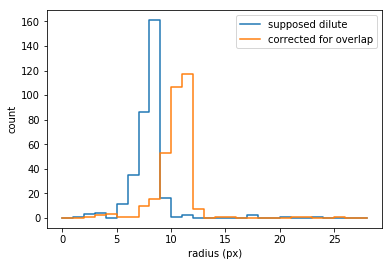

In [16]:
histR1, bins = np.histogram(radii1, bins=np.arange(30))
plt.step(bins[:-1], histR0, label='supposed dilute');
plt.step(bins[:-1], histR1, label='corrected for overlap');
plt.xlabel('radius (px)');
plt.ylabel('count');
plt.legend(loc='upper right');

It is always possible to iterate first and second steps above.

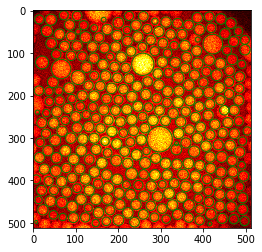

In [18]:
brights2 = track.solve_intensities(s, bonds, dists, centers[:,-1], R0=radii1)
radii2 = track.global_rescale_intensity(s, bonds, dists, brights1, R0=radii1)
draw_circles(centers[:,0], centers[:,1], radii2, facecolor='none', edgecolor='g')
plt.imshow(im, 'hot');

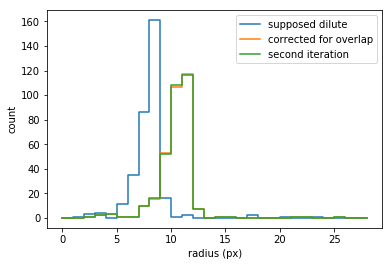

In [19]:
histR2, bins = np.histogram(radii2, bins=np.arange(30))
plt.step(bins[:-1], histR0, label='supposed dilute');
plt.step(bins[:-1], histR1, label='corrected for overlap');
plt.step(bins[:-1], histR2, label='second iteration');
plt.xlabel('radius (px)');
plt.ylabel('count');
plt.legend(loc='upper right');

But most of the times it does not help much.